In [1]:
# -*- coding: utf-8 -*-
from sys import path
path.append('../')
import hsim.core.pymulate as pym
from hsim.core.chfsm import CHFSM, Transition, State
import pandas as pd
import numpy as np
from simpy import AnyOf
from copy import deepcopy
from random import choices,seed,normalvariate, expovariate
from hsim.core.stores import Store, Box       
from scipy import stats
import dill
import hsim.core.utils as utils
pd.set_option('future.no_silent_downcasting', True)
import copy
import numpy as np
import torch
import torch.nn as nn
import random
from collections import deque 
import math
import os
import matplotlib.pyplot as plt
import time

c:\Users\Utente\GitHub\hsim\hsim\core\core.py:57: UserWarning: Bypassing "None" callbakcs
  warn('Bypassing "None" callbakcs')


In [7]:

def plot_service_times(service_times_log):
    df = pd.DataFrame(service_times_log)
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),  # Aumenta il numero di neuroni
            nn.ReLU(),
            nn.Linear(512, 512),  # Aggiungi più strati
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.network(x)

import random
from collections import deque

class DQNAgent:
    def __init__(self, To, state_dim, action_dim,max_time):
        self.state_dim = state_dim
        self.dim = action_dim
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon =1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.03
        self.total_production_time = To
        self.model = DQN(state_dim, action_dim)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001)
        self.criterion = nn.MSELoss() 
        self.accumulated_rewards = list([])#deque(maxlen=10000)
        self.current_time=0
        self.max_time= max_time
        self.episode_count = 0
        self.previous_total_reward = float('inf')
        self.rewards_window = deque(maxlen=100)
        self.finreward=0

    def save_model(self):
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'epsilon': self.epsilon,
                'memory': list(self.memory),
                'previous_total_reward': self.previous_total_reward # Salva la memoria come lista
            }, 'dqn_model.pth')
            print("Model saved to dqn_model.pth")
    
    def load_model(self):
        try:
            checkpoint = torch.load('dqn_model.pth')
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.epsilon = checkpoint['epsilon']
            # print(f'questa è epsilon {self.epsilon}')
            self.memory = deque(checkpoint['memory'], maxlen=10000)
            self.previous_total_reward = checkpoint.get('previous_total_reward',float('inf') )  # Carica la memoria
            self.model.train()  # Imposta il modello in modalità di addestramento
            #self.model.eval()  # Imposta il modello in modalità di valutazione
            print("Model loaded from dqn_model.pth")
        except FileNotFoundError:
            print("No saved model found, starting with a new model")
    
    # def update_last_transition(self):
    #     if not self.memory:
    #         print("Memory is empty, no transition to update.")
    #         return
        
    #     final_reward = self.calculate_final_reward()
    #     # print(f'il reward finale è: {final_reward}')
    #     # state=lab.gate.get_state(lab.b_df)
    #     # self.memory.append((state, action, final_reward, next_state, done))
        
    #     # Estrai l'ultima transizione dalla memoria
    #     last_transition = self.memory[-1]
    #     last_transition = list(last_transition)
    #     last_transition[2]=final_reward
    #     last_transition[4]=True
    #     last_transition=tuple(last_transition)
    #     self.memory[-1]=last_transition
    #     # Verifica che la transizione abbia la struttura corretta
    #     # if len(last_transition) != 5:
    #     #     print("Invalid transition format.")
    #     #     return
        
    #     # last_state, last_action, last_reward, last_next_state, last_done = last_transition
        
    #     # Aggiorna l'ultima transizione con il reward finale e imposta done a True
    #     # modified_transition = (last_state, last_action, final_reward, last_next_state, True)
    #     # self.memory[-1] = modified_transition
        
    #     # Pulisce le ricompense accumulate
    #     self.accumulated_rewards.clear()
        
    #     # Salva il modello
    #     self.save_model()
    def update_last_transition(self):
        if not self.memory:
            print("Memory is empty, no transition to update.")
            return
        
        # Trova l'ultimo episodio
        last_episode = [] 
        count = 0
        for transition in reversed(self.memory):
            count += 1
            if transition[4]:  # Se done è True
                break
            last_episode.insert(0, transition)
        
        if not last_episode:
            print("No complete episode found in memory.")
            return
        
        final_reward = self.calculate_final_reward()
        print(f"Final reward: {final_reward}")
        min_reward=0
        max_reward=self.total_production_time
        # Aggiorna i reward delle transizioni nell'episodio
        try:
            for t in range(len(last_episode)):
                state, action, reward, next_state, done = last_episode[t]
                discount_factor = self.gamma ** (len(last_episode) - t - 1)
                if t == len(last_episode) - 1:
                    print(f"questo è quanto è lungo episodio {t} -1")
                    normalized_rewards = [(final_reward - min_reward) / (max_reward - min_reward)]
                    last_episode[t] = (state, action, normalized_reward, next_state, True)
                else:
                    # Somma il reward finale scontato al reward intermedio
                    discounted_final_reward = discount_factor * final_reward
                    updated_reward = reward + discounted_final_reward
                    normalized_reward = (updated_reward - min_reward) / (max_reward - min_reward)
                    last_episode[t] = (state, action, updated_reward, next_state, done)
        except IndexError as e:
            print(f"IndexError encountered: {e}")
            return
        
        # Rimuovi le transizioni dell'ultimo episodio dalla memoria
        for _ in range(len(last_episode)):
            self.memory.pop()
        
        # Aggiungi le transizioni aggiornate alla memoria
        self.memory.extend(last_episode)
        
        # Pulisce le ricompense accumulate
        self.accumulated_rewards.clear()
        
        # Salva il modello
        self.save_model()
    
    def remember(self, state, action, reward, next_state, done):
        state = np.array(state)
        next_state = np.array(next_state)
        state = np.nan_to_num(state, nan=9999)
        next_state = np.nan_to_num(next_state, nan=9999)
        if state is None or action is None or reward is None or next_state is None:
            print("Invalid entry detected, skipping insertion")
        if action != -1 or reward is not None:
            self.accumulated_rewards.append(reward)
            # print(f"Accumulated rewards: {reward} che aggiungo")
            self.memory.append((state, action, reward, next_state, done))
        else:
            pass


    def isdone(self,env):
        if env.now >= self.max_time:
            # print("Simulation finished")
            # self.save_model()
            return True
        return False
       
    def calculate_final_reward(self):
        # Calcola il makespan come reward
        reward_f=self.finreward
        # Penalizza se il magazzino non è vuoto
        if lab.gate.Store.items:
            print("Store is not empty, penalizing")
            penalty = 500  # Penalità normalizzata
            reward_f -= penalty
        # print(f"Makespan: {makespan}, Normalized reward: {normalized_reward}")
        # return normalized_reward
        return reward_f
   
    

    
        # print(f"State: {state}, Action: {action}, Reward: {reward}, Next State: {next_state}, Done: {done}")
        # print(f"Memory before append: {self.memory}")
        # self.memory.append((state, action, reward, next_state, done))
        # print(f"Memory after append: {self.memory}")
        
        # if not done:
        #     print(f"Accumulated rewards before: {self.accumulated_rewards}")
        #     if len(self.accumulated_rewards) > 0:
        #         self.accumulated_rewards[-1] += reward
        #     print(f"Accumulated rewards after: {self.accumulated_rewards}")
        # else:
        #     delayed_reward = self.get_reward(state)
        #     print(f"Delayed reward: {delayed_reward}")
        #     self.accumulated_rewards.append(delayed_reward)
        #     print(f"Accumulated rewards after append: {self.accumulated_rewards}")
    

    # def act(self, state): 
    #     if isinstance(state, pd.DataFrame):
    #         # state = state.fillna()  # Riempie i valori NaN con 0
    #         state = state.infer_objects(copy=False)
    #         type_col_index = state.columns.get_loc('type')
    #         entity_index= state.columns.get_loc('Entity')
    #         states = state.to_numpy()
    #         if np.random.rand() <= self.epsilon:
    #             filtered_state = states[state['type'] == 0]
    #             ris=random.choice(filtered_state['Entity'].tolist())
    #         else:
    #             return print("ERROR")
    #     q_values= self.model.predict(state)
    #     return np.argmax(q_values[0])

    def act(self, state, type_col_index, entity_col_index):
        if isinstance(state, np.ndarray):
            state = np.nan_to_num(state, nan=9999)
            if np.random.rand() <= self.epsilon:
                # Filtra le righe dove 'type' è 0
                filtered_state = state[state[:, type_col_index] == 0]
                # print(f'filtered_state shape {filtered_state.shape}')
                if filtered_state.size > 0:
                    selected_value=random.choice(filtered_state[:, entity_col_index].tolist())
                    for i in range(len(filtered_state)):
                        if state[i][entity_col_index] == selected_value:
                            # print(i)
                            return i
                else:
                    i=-1
                    return i
            else:
                # Usa il modello per predire i Q-values e seleziona l'azione con il valore massimo
                # print("EXPLOIT")
                # print(state.shape)
                state_tensor = torch.FloatTensor(state)
                q_values = self.model(state_tensor)
                max_index=int(np.argmax(q_values.detach().numpy()[0]))
                # print(f"Max index: {max_index}")
                if max_index < 0 or max_index > len(state):
                    i=-1
                    return i
    
                return max_index
        else:
            print("State is not a NumPy array")
            return None
        
    # def update_epsilon(self):
    #     # Aggiorna epsilon per ridurre gradualmente l'esplorazione
    #     if self.epsilon > self.epsilon_min:
    #         self.epsilon *= self.epsilon_decay   
    
    def get_reward(self, state,colonne,action,flag):
        
                # Verifica che state sia un array NumPy
        if not isinstance(state, np.ndarray):
            raise ValueError("state deve essere un array NumPy")

        # Verifica che columns sia un array NumPy
        if not isinstance(colonne, np.ndarray):
            raise ValueError("columns deve essere un array NumPy")
        if action==-1 and lab.gate.Store.items:
            reward= -100
        else:
            reward= 0
        # if action==-1 and not lab.gate.Store.items:
        #     reward=0
        # if action!=-1:
        #      reward= 50
        try:
            time_out_index = np.where(colonne == 'timeOut')[0][0]
            time_in_index = np.where(colonne == 'timeIn')[0][0]
        except IndexError:
            raise ValueError("columns deve contenere 'timeOut' e 'timeIn'")

        state[:, time_in_index] = np.nan_to_num(state[:, time_in_index], nan=9999)
        
        state[:, time_out_index] = np.nan_to_num(state[:, time_out_index], nan=9999)
        
        max_time_out = np.nanmax(state[:, time_out_index])
        min_time_in = np.nanmin(state[:, time_in_index])
        # makespan = np.nanmax(state[:, time_out_index]) - np.nanmin(state[:, time_in_index])
        if max_time_out == 9999:
            valid_times_out = state[:, time_out_index][state[:, time_out_index] != 9999]
            if len(valid_times_out) > 0:
                max_time_out = np.nanmax(valid_times_out)
                # print(f"Max time out: {max_time_out}")
            else:
                # print("non ci sono tempi diversi")
                max_time_out = 0
        # print(max_time_out)
        makespan = max_time_out - min_time_in
        # print(f"Makespan: {makespan}")
        self.finreward= -makespan
        # if makespan == 0:
        #     reward = 0
        #     # print("Makespan is 0")
        # else:
        #     reward = - makespan
        return reward

    
    # def replay(self, batch_size):
    #     if len(self.memory) < batch_size:
    #         return 
    #     priorities = np.array([1.0 if transition[4] else 0.1 for transition in self.memory])
    #     probabilities = priorities / priorities.sum()
    #     indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
    #     minibatch = [self.memory[idx] for idx in indices]
    #     # minibatch = random.sample(self.memory, batch_size)
    #     for state, action, reward, next_state, done in minibatch:           
            
    #         next_state=np.nan_to_num(next_state, nan=9999)
    #         next_state = torch.FloatTensor(next_state)
    #         target = reward
    #         # print(f"reward campionato: {reward}")
    #         if reward is None:
    #             print("Reward is None")
    #             continue
    #         if not done:
    #             target = reward + self.gamma * torch.max(self.model(next_state)[0]).item()
    #         # Converti state in un tensore PyTorch e aggiungi una dimensione extra
    #         state=np.nan_to_num(state, nan=9999)
    #         state = torch.FloatTensor(state) 
    #         # print(state.shape)       
    #         # Calcola target_f usando il modello
    #         target_f = self.model(state)
    #           # Verifica che action sia un intero valido
    
    #         if isinstance(action, float):
    #             action = int(action)
    #         # if not isinstance(action, int):
    #         #     print(f"Action sbagliata: {action}")
    #         #     raise ValueError("action deve essere un intero")
    #         # print(action)
    #         if not isinstance(action, int):
    #             # print(f"Action sbagliata: {action}")
    #             raise ValueError("action deve essere un intero")
    #         # print(f"state shape: {state.shape}")
    #         # print(f"next_state shape: {next_state.shape}")
    #         # print(f"target_f shape: {target_f.shape}")
    #         # print(f"action: {action}")           
    #         # if action <0 or action >= target_f.size(1):   # Modificato da size(1) a size(2)
    #         #     raise IndexError("action non è un indice valido per target_f")
    #         if action <0 or action >= target_f.size(1): #target is  None 
    #             pass
    #         else:               
    #             target_f[0][action] = target

            
    #         # Ottimizza il modello
    #         self.optimizer.zero_grad()
    #         loss = self.criterion(target_f, self.model(state))
    #         loss.backward()
    #         self.optimizer.step()
        
    #     if self.epsilon > self.epsilon_min:
    #         self.epsilon *= self.epsilon_decay
        
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            print("Not enough samples in memory to replay.")
            return
        
        # Trova gli indici degli episodi completi
        episode_indices = []
        current_episode = []
        for idx, transition in enumerate(self.memory):
            current_episode.append(transition)
            if transition[4]:  # Se done è True
                episode_indices.append(current_episode)
                current_episode = []
        
        if len(episode_indices) < batch_size:
            # print("Not enough episodes in memory to replay.")
            return
        
        # Assegna priorità decrescente agli episodi in base alla loro posizione nella memoria
        priorities = np.linspace(1.0, 0.1, len(episode_indices))
        probabilities = priorities / priorities.sum()
        
        # Campiona batch_size episodi completi
        sampled_episodes = np.random.choice(len(episode_indices), batch_size, p=probabilities)
        minibatch = [episode_indices[idx] for idx in sampled_episodes]
        
        total_loss = 0.0  # Inizializza total_loss a zero
        num_transitions = 0  # Contatore per il numero di transizioni
        
        for episode in minibatch:
            for state, action, reward, next_state, done in episode:
                next_state = torch.FloatTensor(np.nan_to_num(next_state, nan=9999))
                state = torch.FloatTensor(np.nan_to_num(state, nan=9999))
                action = torch.LongTensor([action])
                reward = torch.FloatTensor([reward])
                
                # Calcola il valore target utilizzando la formula di Bellman
                target = reward
                if not done:
                    target += self.gamma * torch.max(self.model(next_state)).item()
                
                # Calcola i valori predetti dal modello
                current_q_values = self.model(state)
                
                # Clona i valori predetti per aggiornare il valore target per l'azione specifica
                target_f = current_q_values.clone().detach()
                target_f[0][action] = target
                
                # Calcola la perdita tra i valori predetti e i valori target
                loss = self.criterion(current_q_values, target_f)
                
                # Ottimizza il modello
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()  # Aggiorna total_loss con il valore scalare della loss
                num_transitions += 1  # Incrementa il contatore delle transizioni
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Calcola la perdita media
        avg_loss = total_loss / num_transitions if num_transitions > 0 else float('inf')

        # Stampa il valore medio del reward e della perdita (loss) per monitorare l'apprendimento
        avg_reward = np.mean([transition[2] for transition in self.memory])
        print(f"Average reward: {avg_reward}, Average loss: {avg_loss}")


# class Generator(pym.Generator):
#     def __init__(self,env,name=None,serviceTime=2,serviceTimeFunction=None):
#         super().__init__(env,name,serviceTime,serviceTimeFunction)
#         self.count = 0
#         self.entities=pd.DataFrame(columns=['id', 'Entity', 'front', 'drill', 'robot', 'camera', 'back', 'press', 'manual'])
#     def createEntity(self):
#         self.count += 1
#         # return Entity()
#         e = Entity()#ID=self.count)
#         #e.serviceTime = dict()
#         e.serviceTime['front'] = 10.52
#         e.serviceTime['drill'] = choices([3.5, 8.45, 9.65, 11.94],weights=[5,30,30,35])[0] ## Insert the possibility of skipping this stage
#         e.serviceTime['robot'] = choices([0, 81, 105, 108 ,120],weights=[91,3,2,2,2])[0]
#         # e.serviceTime['camera'] = choices([3,9,12,18,24],weights=[2,3,1,2,2])[0]
#         e.serviceTime['camera'] = 3.5+expovariate(1/7.1)
#         e.serviceTime['back'] = choices([3.5,10.57],weights=[0.1,0.9])[0]
#         # e.serviceTime['press'] = choices([3,9,15])[0]
#         if e.serviceTime['back']>0:
#             e.serviceTime['press'] = 3.5+expovariate(1/9.5)
#         else:
#             e.serviceTime['press'] = 3.5
#         e.serviceTime['manual'] = max(np.random.normal(9.2,1),0)
#         #print(f"Entity {self.count} service times: {e.serviceTime}")
#         # self.entities.append(e)
#         service_time_dict = {f'serviceTime_{i}': [time] for i, time in enumerate(e.serviceTime)}
#         entity_dict = {
#             'id': e.ID,
#             'Entity': e,
#             'front': e.serviceTime['front'],
#             'drill': e.serviceTime['drill'],
#             'robot': e.serviceTime['robot'],
#             'camera': e.serviceTime['camera'],
#             'back': e.serviceTime['back'],
#             'press': e.serviceTime['press'],
#             'manual': e.serviceTime['manual']
#         }

#         entity_df = pd.DataFrame([entity_dict])
#         lab.b_df = pd.concat([lab.b_df, entity_df], ignore_index=True)
#         # print(f"ho aggiunto un'unità al batch:\n{lab.b_df.iloc[-1]}")
#         # print("il nuovo batch è:")
#         # print(lab.b_df)
#         # print(lab.b_df.shape[1])
#         # self.entities = pd.concat([self.entities, entity_df], ignore_index=True)
#         # entity_df = pd.DataFrame([e.ID, e, pd.DataFrame(e.serviceTime)], columns=['id', 'Entity', 'front', 'drill', 'robot', 'camera', 'back', 'press', 'manual'])
#         # self.entities = pd.concat([self.entities, entity_df], ignore_index=True)
#         return e
#     # def get_entities_service_times(self,entities):
#     # # Convert the 'serviceTime' column to a DataFrame
#     #     service_times_df = pd.DataFrame(entities['serviceTime'].tolist())
    
#     # # Concatenate the 'id', 'Entity', and the new service times DataFrame
#     #     data = pd.concat([entities[['id', 'Entity']], service_times_df], axis=1)
#     #     print(data)
#     #     return data
    
class Entity:
    _id_counter=0
    def __init__(self,ID=None):
        if ID is None:
            self.ID = Entity._id_counter
            Entity._id_counter += 1
            # print(f"sto creando un Entity ID: {self.ID}")
        else:
            self.ID = ID
        self.rework = False
        self.serviceTime = dict()
        # self.pt['M3'] = 1

    def reset_id_counter():
        Entity._id_counter = 0
    @property
    def require_robot(self):
        if self.serviceTime['robot']>0:
            return True
        else:
            return False
    @property
    def ok(self):
        return not (self.rework and self.require_robot)
    def done(self):
        self.rework = False
                
class LabServer(pym.Server):
    def __init__(self,env,name=None,serviceTime=None,serviceTimeFunction=None):
        self.controller = None
        # serviceTime = 10
        super().__init__(env,name,serviceTime,serviceTimeFunction)
    def calculateServiceTime(self,entity=None,attribute='serviceTime'):
        if not entity.ok:
            return 20 #3.5 ### qua andrà messo 10/20 volte maggiore degli altri processing time?
        else:
            print("service time")
            print(super().calculateServiceTime(entity,attribute))
            return super().calculateServiceTime(entity,attribute)
    def completed(self):
        if self.var.entity.ok:
            self.controller.Messages.put(self.name)
    T2=Transition(pym.Server.Working, pym.Server.Blocking, lambda self: self.env.timeout(self.calculateServiceTime(self.var.entity)), action = lambda self: self.completed())
    T3=Transition(pym.Server.Blocking, pym.Server.Starving, lambda self: self.Next.put(self.var.entity),action=lambda self: [self.var.request.confirm(), self.sm.var.entity.done() if self.sm._name=='robot' else None])

def plot_service_times(service_times_log):
    df = pd.DataFrame(service_times_log)
    df.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.xlabel('Entity')
    plt.ylabel('Service Time')
    plt.title('Service Times of Entities')
    plt.legend(title='Service Stages')
    plt.show()


class Terminator(pym.Terminator):
    def __init__(self, env, capacity=np.inf):
        super().__init__(env, capacity)
        self.controller = None
        self.register = list()
    def completed(self):
        if not self.trigger.triggered:
            self.trigger.succeed()
    def put(self,item):
        self.register.append(self._env.now)
        self.controller.Messages.put('terminator')
        return super().put(item)
    def subscribe(self,item):
        self.register.append(self._env.now)
        self.controller.Messages.put('terminator')
        return super().subscribe(item)
class Gate(CHFSM):
    def __init__(self,env,tempo,statedim,actiondim,max_time):
        self.real = True
        self.default_request_count = 0
        self.capacity = 30 #check se è giusto 40 o 30 come era prima
        self.lab = None
        self.initialWIP = 12
        self.targetWIP = 12
        self.request = None
        self.episode_count = 0
        self.message = env.event()
        self.WIP = 0
        self.WIPlist = list()
        self.dones=False 
        self.training_step=0
        self.dqn_agent = DQNAgent(tempo,state_dim=statedim, action_dim=actiondim,max_time=max_time)
        self.dqn_agent.load_model()
        # self.count=len(b)
        super().__init__(env) #prima era in fondo ai self
# # #AGGIUNTA
    def concatenate_state_dataframes(self, batch_df, machine_df):
        batch_df['type'] = 0  # 0 per batch
        machine_df['type'] = 1  # 1 per macchina
        dfi= pd.concat([batch_df, machine_df], axis=0, sort=False).reset_index(drop=True)
        dfi.to_excel('dfi.xlsx')
        return dfi

    def convertdataframe(self,df,flag=True):
        mapping = {
            "front": 1,
            "drill": 2,
            "robot": 3,
            "camera": 4,
            "back": 5,
            "press": 6,
            "manual": 7
        }
        df["ResourceName"] = df["ResourceName"].map(mapping)

        mapping2 = {
            "Working": 1,
            "Blocking": 2,
            "Starving": 3
        }  
        df["StateName"] = df["StateName"].map(mapping2)
        df["Entity"] = df["id"]
        
        # filtered_df = df[df["type"] == 0]

        # # Verifica e conversione della colonna "id" se è di tipo float
        # if filtered_df["id"].dtype == float:
        #     df.loc[df["type"] == 0, "id"] = df.loc[df["type"] == 0, "id"].astype(int)

        # # Verifica e conversione della colonna "Entity" se è di tipo float
        # if filtered_df["Entity"].dtype == float:
        #     df.loc[df["type"] == 0, "Entity"] = df.loc[df["type"] == 0, "Entity"].astype(int)
        
        df.to_excel('conversionenumpy.xlsx')
        data_array=df.to_numpy()
        column_names = df.columns.to_numpy()

        # print(column_names)
        if flag:
            return data_array
        else:
            return data_array, column_names

    
    
    def filtro(self,val):
        return lambda item: item == val
    
    def indexcolumns(self,column):
        type_col_index = list(column).index('type')
        entity_col_index = list(column).index('Entity')
        return type_col_index, entity_col_index
    
    def action_to_request(self,indice,current_state):
        if indice is None or indice < 0 or indice >= current_state.shape[0] :
            # print(f"Indice negativo: {indice}")
            return None
        element=None
        for i in range(current_state.shape[0]):
            if i == indice:
                element=current_state[i, 0]
                # print(f"Elemento selezionato: {element}")
                break
                
        if element is not None:
            row = lab.b_df.loc[lab.b_df['id'] == element]
            if not row.empty:
                values = row['Entity'].values[0]
                return values   
            else:
        # print(f"No entity found with id {element}")
                return None
        else:
            return None


    def get_state(self,b_df,val=True):
        machine_df=pd.DataFrame(self.env.log,columns=["ResourceName","StateName","timeIn","timeOut"])
        machine_df=machine_df.loc[machine_df.ResourceName.isin(["front","drill","robot","camera","back","press","manual"])]
        batch_df = b_df[b_df['Entity'].isin(lab.gate.Store.items)] # Filtra solo le righe del batch che sono presenti nello store
        spazio_stati=self.concatenate_state_dataframes(batch_df,machine_df)
        spazio_stati.to_excel('spazio_stati.xlsx')
        spazio_stati,index = self.convertdataframe(spazio_stati,flag=False)
        # print(spazio_stati.dtype)
        if val:
            return spazio_stati
        else:
            return spazio_stati, index
    

    # def get_next_state(self,b):
    #     machine_df = pd.DataFrame(self.env.log, columns=["ResourceName","StateName","timeIn", "timeOut"])
    #     machine_df=machine_df.loc[machine_df.ResourceName.isin(["front","drill","robot","camera","back","press","manual"])]
    #     batch_df = b[b['Entity'].isin(lab.gate.Store.items)]  # Filter only the rows of the batch that are present in the store
    #     new_spazio_stati = self.concatenate_state_dataframes(batch_df, machine_df)
    #     new_spazio_stati=self.convertdataframe(new_spazio_stati)
    #     return new_spazio_stati

    # def update_delayed_reward(self, reward):
    #     if len(self.accumulated_rewards) > 0:
    #         self.accumulated_rewards[-1] += reward # If there are, add the new reward to the last element
    #     else:
    #         self.accumulated_rewards.append(reward) 

    # def doneboole(self,env):
    #     self.dones=self.dqn_agent.is_done(env)
    #     return self.dones
    
  
    
    
    # def condition(self, item, scheduled_request):
    #     if scheduled_request in self.Store.items:
    #         # return item == self.Store.items[scheduled_request]
    #         return lab.gate.Store.get(scheduled_request)
    #     else:
    #         # Gestisci il caso in cui l'indice sia fuori dai limiti
    #         print(f"Indice {scheduled_request} fuori dai limiti")
    #         return False

    
    # def get(self, condition):
    #     for item in self.Store.items:
    #         if condition(item):
    #             return item
    #     return None

    # def custom_condition(self, item, scheduled_request):
    #     return self.condition(item, scheduled_request)

#FINE AGGIUNTA
    def build(self):
        self.Store = pym.Store(self.env,self.capacity)
        self.Messages = pym.Store(self.env)
    def put(self,item):
        return self.Store.put(item)
    class Loading(State):
        def _do(self):
            # print('Load: %d' %self.sm.initialWIP)
            self.sm.initialWIP -= 1
            self.fw()
    class Waiting(State):
        initial_state = True
        def _do(self):
            self.sm.message = self.Messages.subscribe()
            if self.sm.initialWIP > 0:
                self.initial_timeout = self.env.timeout(1)
            else:
                self.initial_timeout = self.env.event()
    class Forwarding(State):
        def _do(self):
            self.message.confirm()
            if self.message.value == 'terminator':
                self.sm.WIP -= 1
                self.sm.WIPlist.append([self.env.now,self.WIP])
                # print(self.sm.WIPlist)
            self.FIFO()
            self.CONWIP()
    
    def CONWIP(self):
        if self.message.value == 'terminator':
            self.fw()
    def FIFO(self):
        pass
  
    def fw(self):  
        if self.request is None:
           #self.request = self.Store.get(self.filtro('<__main__.Entity object at 0x00000222C40317D0>'))
#INIZIO NUOVO CODICE
            # count=len(lab.gate.Store.items)
            # print(f'numero di entità nello store {count}')
            flag=0
            current_state,columns = self.get_state(lab.b_df,val=False)
            # pd.DataFrame(current_state).to_excel('current_state.xlsx')
            type_col_index, entity_col_index = self.indexcolumns(columns)
            action=self.dqn_agent.act(current_state,type_col_index, entity_col_index) #index intero
            # print(f'azioni selezionate indice{action}')            
            # count=len(lab.gate.Store.items)
            actionselct = self.action_to_request(action,current_state) #entity
            # print(f'azioni selezionate {actionselct}')
            # if lab.gate.Store.items:
            
            
            if actionselct is not None:
                flag=1
                self.request = self.Store.get(self.filtro(actionselct))
                # print(f"Request: {self.request}")
                # print(len(lab.gate.Store.items))
                # print(self.request)
                self.Next.put(self.request.value)
                self.request = None
                self.WIP += 1
                self.WIPlist.append([self.env.now,self.WIP])
            
            next_state=self.get_state(lab.b_df)
            reward = self.dqn_agent.get_reward(current_state,columns,action,flag)
            # if flag==0:
            #     pass
            # else:
            #     self.dqn_agent.remember(current_state, action, reward, next_state, self.dones)
            #     self.episode_count += 1
            self.dqn_agent.remember(current_state, action, reward, next_state, self.dones)
            self.episode_count += 1
            if self.episode_count % 5 == 0:
                if len(self.dqn_agent.memory) > 10:
                    self.dqn_agent.replay(8)
                    

      
        else:
            print('Error: request is not None')
            pass
        
       
    
             

    T0 = Transition(Waiting,Loading,lambda self: self.initial_timeout)
    T1 = Transition(Waiting,Forwarding,lambda self: self.sm.message)
    T2 = Transition(Loading,Waiting,None)
    T3 = Transition(Forwarding,Waiting,None)
         

class Router(pym.Router):
    def __deepcopy(self,memo):
        super().deepcopy(self,memo)
    def __init__(self, env, name=None):
        super().__init__(env, name)
        self.var.requestOut = []
        self.var.sent = []
        self.putEvent = env.event()
    def build(self):
        self.Queue = Box(self.env)
    def condition_check(self,item,target):
        return True
    def put(self,item):
        if self.putEvent.triggered:
            self.putEvent.restart()
        self.putEvent.succeed()
        return self.Queue.put(item)
    class Sending(State):
        initial_state = True
        def _do(self):
            self.sm.putEvent.restart()
            self.sm.var.requestIn = self.sm.putEvent
            self.sm.var.requestOut = [item for sublist in [[next.subscribe(item) for next in self.sm.Next if self.sm.condition_check(item,next)] for item in self.sm.Queue.items] for item in sublist]
            if self.sm.var.requestOut == []:
                self.sm.var.requestOut.append(self.sm.var.requestIn)
    S2S2 = Transition(Sending,Sending,lambda self:AnyOf(self.env,self.var.requestOut),condition=lambda self:self.var.requestOut != [])
    def action2(self):
        self.Queue._trigger_put(self.env.event())
        if not hasattr(self.var.requestOut[0],'item'):
            return
        for request in self.var.requestOut:
            if not request.item in self.Queue.items:
                request.cancel()
                continue
            if request.triggered:
                if request.check():
                    request.confirm()
                    self.Queue.forward(request.item)
                    continue
    S2S2._action = action2
'''  
from pymulate import RouterNew
class Router(RouterNew):
    def __init__(self, env, name=None):
        capacity=1
        super().__init__(env, name,capacity)
'''
class RobotSwitch1(Router):
    def condition_check(self, item, target):
        if item.require_robot:
            item.rework = True
        if item.require_robot and target.name == 'convRobot1S':
            return True
        elif not item.require_robot and target.name != 'convRobot1S':
            return True
        else:
            return False
            
class RobotSwitch2(Router):
    def condition_check(self, item, target):
        if len(target.Next)<2:
            item.rework = False
            return True
        else:
            item.rework = True
            return False    

class CloseOutSwitch(Router):
    def condition_check(self, item, target):
        if item.ok and type(target) == Terminator:
            return True
        elif not item.ok and type(target) != Terminator:
            return True
        else:
            return False
        
# class Conveyor(pym.ParallelServer):
#     def __init__(self,env,name=None,serviceTime=None,serviceTimeFunction=None,capacity=1):
#         self._capacity = capacity
#         serviceTime = capacity*3.5
#         super().__init__(env,name,serviceTime,serviceTimeFunction,capacity)
class Conveyor(pym.Conveyor):
    def __init__(self,env,name=None,capacity=3):
        super().__init__(env,name,capacity,0.75)
        
def newDT():
    lab = globals()['lab']
    deepcopy(lab)

def newEntity():
    seed(time.time())
    e = Entity()
    e.serviceTime['front'] = 10.52
    e.serviceTime['drill'] = choices([30, 40, 50, 20],weights=[5,30,30,35])[0]
    e.serviceTime['robot'] = choices([0, 81, 105, 108 ,120],weights=[91,3,2,2,2])[0]
    e.serviceTime['camera'] = 3.5+expovariate(1/7.1)
    e.serviceTime['back'] = choices([3.5,10.57],weights=[0.1,0.9])[0]
    if e.serviceTime['back']>0:
        e.serviceTime['press'] = 3.5+expovariate(1/7.5)
    else:
        e.serviceTime['press'] = 3.5
    e.serviceTime['manual'] = max(np.random.normal(9.2,2),0)
    return e

def batchCreate(seed=1,numJobs=10,return_both=False):
    np.random.seed(seed)
    jList = []
    complist = []
    while len(jList)<numJobs:
        e=newEntity()
        # num = round(np.random.triangular(1,numJobs/2,numJobs))
        # # print(num)
        # for i in range(num):
        jList.append(e)
        entity_info = {
                'id': e.ID,
                'Entity': e,
                'serviceTime': e.serviceTime
                }
        complist.append(entity_info)
        if len(jList)>=numJobs:  # l'ho aggiunto io per evitare che si creino più entità di quelle richieste
            break
    if return_both:
        return jList, complist
    else:
        return jList

class Lab():
    def __init__(self,b,maxtime):
        conveyTime = 6
        self.env = pym.Environment() #crea l'ambiente
        # self.g = Generator(self.env) #genera un nuovo pezzo
        
        self.a=self.env.log  #ambiente stati macchine è un dataframe della lista self.state_log
        self.machine_df=pd.DataFrame(self.a,columns=["ResourceName","StateName","timeIn","timeOut"])
        self.machine_df=self.machine_df.loc[self.machine_df.ResourceName.isin(["front","drill","robot","camera","back","press","manual"])]
        self.machine_df.to_excel('machine_df.xlsx')
        
        b_df = pd.DataFrame(b)
        self.b_df=pd.concat([b_df['id'],b_df['Entity'], pd.DataFrame(b_df['serviceTime'].tolist())],axis=1)
        self.b_df.to_excel('b_df.xlsx')
        self.dim_state=self.b_df.shape[1]+self.machine_df.shape[1]+1 #14
        self.dim_action=len(b_df) #come la capacity
        self.list = []
        service_time_columns = ["front", "drill", "robot", "camera", "back", "press", "manual"]
        service_time_columns = [col for col in service_time_columns if col in self.b_df.columns]
        self.tmax = self.b_df[service_time_columns].sum().sum()
        # print(f"questo è tmax {self.tmax}")
        self.gate = Gate(self.env,tempo=self.tmax,statedim=self.dim_state,actiondim=self.dim_action,max_time=maxtime) #crea il gate

        # DR= despaching rule OR=order release 
        # self.conv1 = Conveyor(self.env,capacity=3)
        self.conv1S = pym.Server(self.env,serviceTime=conveyTime) 
        self.conv1Q = pym.Queue(self.env,capacity=2)
        self.front = LabServer(self.env,'front')
        # self.conv2 = Conveyor(self.env,capacity=3)
        self.conv2S = pym.Server(self.env,serviceTime=conveyTime)
        self.conv2Q = pym.Queue(self.env,capacity=2)
        self.drill = LabServer(self.env,'drill')
        # self.conv3 = Conveyor(self.env,capacity=3)
        self.conv3S = pym.Server(self.env,serviceTime=conveyTime)
        self.conv3Q = pym.Queue(self.env,capacity=2)

        
        self.switch1 = RobotSwitch1(self.env)
        # self.convRobot1 = Conveyor(self.env,'convRobot1',capacity=3)
        self.convRobot1S = pym.Server(self.env,serviceTime=conveyTime,name='convRobot1S')
        self.convRobot1Q = pym.Queue(self.env,capacity=2)

        # self.bridge = Conveyor(self.env,capacity=3)
        self.bridgeS = pym.Server(self.env,serviceTime=conveyTime)
        self.bridgeQ = pym.Queue(self.env,capacity=2)

        # self.convRobot2 = Conveyor(self.env,'convRobot2',capacity=3)
        self.convRobot2S = pym.Server(self.env,serviceTime=conveyTime)
        self.convRobot2Q = pym.Queue(self.env,capacity=2)

        self.switch2 = RobotSwitch2(self.env)
        # self.convRobot3 = Conveyor(self.env,capacity=3)
        self.convRobot3S = pym.Server(self.env,serviceTime=conveyTime)
        self.convRobot3Q = pym.Queue(self.env,capacity=2)

        self.robot = LabServer(self.env,'robot')
        # self.convRobotOut = Conveyor(self.env,capacity=3)
        self.convRobotOutS = pym.Server(self.env,serviceTime=conveyTime)
        self.convRobotOutQ = pym.Queue(self.env,capacity=2)
        # self.conv5 = Conveyor(self.env,capacity=3)
        self.conv5S = pym.Server(self.env,serviceTime=conveyTime)
        self.conv5Q = pym.Queue(self.env,capacity=2)

        self.camera = LabServer(self.env,'camera')
        # self.conv6 = Conveyor(self.env,capacity=3)
        self.conv6S = pym.Server(self.env,serviceTime=conveyTime)
        self.conv6Q = pym.Queue(self.env,capacity=2)

        self.back = LabServer(self.env,'back')
        # self.conv7 = Conveyor(self.env,capacity=3)
        self.conv7S = pym.Server(self.env,serviceTime=conveyTime)
        self.conv7Q = pym.Queue(self.env,capacity=2)

        self.press = LabServer(self.env,'press')
        # self.conv8 = Conveyor(self.env,capacity=3)
        self.conv8S = pym.Server(self.env,serviceTime=conveyTime)
        self.conv8Q = pym.Queue(self.env,capacity=2)

        self.manual = LabServer(self.env,'manual')
        self.outSwitch = CloseOutSwitch(self.env)
        self.terminator = Terminator(self.env)
        
        # self.g.Next = self.gate
        self.gate.Next = self.conv1S
        
        # self.conv1.Next = self.front
        self.conv1S.Next = self.conv1Q
        self.conv1Q.Next = self.front

        self.front.Next = self.conv2S
        # self.conv2.Next = self.drill
        self.conv2S.Next = self.conv2Q
        self.conv2Q.Next = self.drill
        self.drill.Next = self.conv3S
        self.conv3S.Next = self.conv3Q
        self.conv3Q.Next = self.switch1
        # self.conv3.Next = self.switch1
        
        self.switch1.Next = [self.convRobot1S,self.bridgeS]
        self.convRobot1S.Next = self.convRobot1Q
        self.convRobot1Q.Next = self.switch2

        self.switch2.Next = [self.convRobot2S,self.convRobot3S]
        self.convRobot2S.Next = self.convRobot2Q
        self.convRobot2Q.Next = self.robot

        self.convRobot3S.Next = self.convRobot3Q
        self.convRobot3Q.Next = self.convRobotOutS

        self.robot.Next = self.convRobotOutS
        self.convRobotOutS.Next = self.convRobotOutQ

        self.convRobotOutQ.Next = self.conv5S
        self.bridgeS.Next = self.bridgeQ
        self.bridgeQ.Next = self.conv5S

        
        self.conv5S.Next = self.conv5Q
        self.conv5Q.Next = self.camera

        self.camera.Next = self.conv6S
        self.conv6S.Next = self.conv6Q
        self.conv6Q.Next = self.back

        self.back.Next = self.conv7S
        self.conv7S.Next = self.conv7Q
        self.conv7Q.Next = self.press

        self.press.Next = self.conv8S
        self.conv8S.Next = self.conv8Q
        self.conv8Q.Next = self.manual

        self.manual.Next = self.outSwitch
        self.outSwitch.Next = [self.conv1S,self.terminator]
        
        for x in [self.front,self.drill,self.robot,self.camera,self.back,self.press,self.manual]:
            x.controller = self.gate
        self.terminator.controller = self.gate
        self.gate.lab = self

       

    def run(self,Tend):
        self.env.run(Tend)
        if self.gate.dqn_agent.isdone(self.env):
            self.gate.dqn_agent.update_last_transition()
            print("Operazione completata")
        else:
            print("Operazione non completata")
        
       #return pd.DataFrame(self.env.state_log)
        return self.env.state_log




Modello esistente trovato al ciclo 0.
No saved model found, starting with a new model


Exception ignored in: <function ZipFile.__del__ at 0x00000212EF60DA80>
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\zipfile.py", line 1894, in __del__
    self.close()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\zipfile.py", line 1911, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


Final reward: -317.6998945573211
questo è quanto è lungo episodio 21 -1
Model saved to dqn_model.pth
Operazione completata
Model saved correctly
Model loaded from dqn_model.pth
Final reward: -604.8334522350588
questo è quanto è lungo episodio 21 -1
Model saved to dqn_model.pth
Operazione completata
Model saved correctly
Model loaded from dqn_model.pth
Final reward: -398.20797705435706
questo è quanto è lungo episodio 21 -1
Model saved to dqn_model.pth
Operazione completata
Model saved correctly
Model loaded from dqn_model.pth
Final reward: -393.6465493336646
questo è quanto è lungo episodio 21 -1
Model saved to dqn_model.pth
Operazione completata
Model saved correctly
Model loaded from dqn_model.pth
Final reward: -502.09230626328724
questo è quanto è lungo episodio 21 -1
Model saved to dqn_model.pth
Operazione completata
Model saved correctly
Model loaded from dqn_model.pth
Final reward: -597.2738592033043
questo è quanto è lungo episodio 21 -1
Model saved to dqn_model.pth
Operazione c

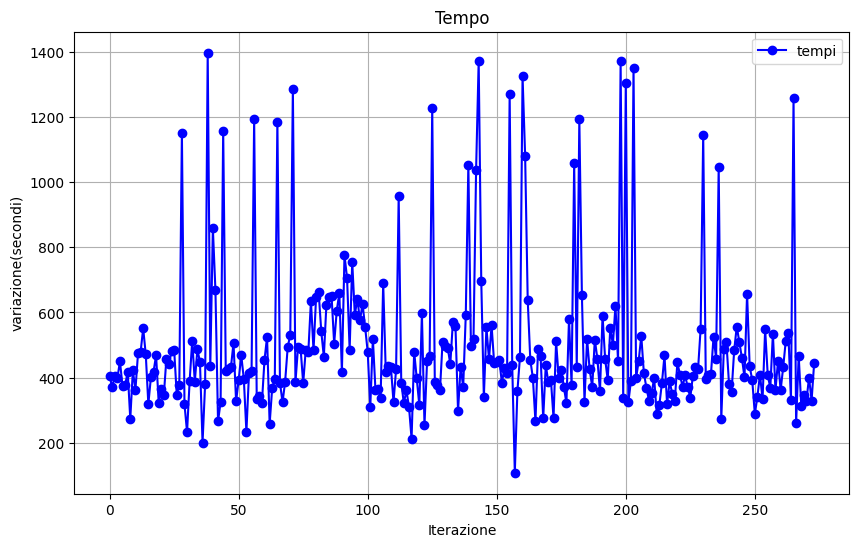

In [8]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
Entity.reset_id_counter()

tempi=list(pd.read_excel('tempi.xlsx')['tempi'])
for i in range(100):
    Entity.reset_id_counter()
    model_path = 'dqn_model.pth'
    if i == 0:
        if os.path.exists(model_path):
            print(f"Modello esistente trovato al ciclo {i}.")
            os.remove(model_path)
        else:
            print(f"Nessun modello esistente trovato al ciclo {i}. Inizio con un nuovo modello.")     #     
    s,b = batchCreate(0,numJobs=10,return_both=True)
    
    lab=Lab(b,1100)
    # lab.gate.Store.items = [item['Entity'] for item in b]
    To=lab.tmax
    lab.gate.Store.items=[]
    lab.gate.Store.items= copy.copy(s)
    if i > 0:
        assert lab.gate.dqn_agent.model is not None, "Model not loaded correctly"
    
    lab.run(1100)

    df = pd.DataFrame(lab.env.state_log, columns=["Resource","ResourceName","State","StateName","Entity","?","timeIn","timeOut"])
    df= df.loc[df.ResourceName.isin(["front","drill","robot","camera","back","press","manual"])]
    mk=df.timeOut.max()-df.timeIn.min()
    mk_dif=To-mk
    tempi.append(mk_dif)
    
    # Verifica che il modello sia stato salvato correttamente
    try:
        checkpoint = torch.load('dqn_model.pth')
        assert 'model_state_dict' in checkpoint, "Model state dict not found in checkpoint"
        print("Model saved correctly")
    except FileNotFoundError:
        print("Model not saved correctly")


mkdif_df = pd.DataFrame(tempi, columns=['tempi'])
mkdif_df.to_excel('tempi.xlsx')
print(tempi)
# Crea il grafico a linee
plt.figure(figsize=(10, 6))
plt.plot(tempi, marker='o', linestyle='-', color='b', label='tempi')

# Aggiungi etichette e titolo
plt.xlabel('Iterazione')
plt.ylabel('variazione(secondi)')
plt.title('Tempo')
plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()

# c=deepcopy(lab.gate.dqn_agent.memory)
# df = pd.DataFrame(c, columns=['state', 'action', 'reward', 'next_state', 'done'])

# # Scrivi il DataFrame su un file Excel
# df.to_excel('dqn_memory.xlsx', index=False)



In [ ]:
lab.gate.dqn_agent.memory[]

In [23]:

c=deepcopy(lab.gate.dqn_agent.memory)
df = pd.DataFrame(c, columns=['state', 'action', 'reward', 'next_state', 'done'])

# Scrivi il DataFrame su un file Excel
df.to_excel('dqn_memory.xlsx', index=False)


In [75]:
def calculate_reward(makespan, target_makespan=500):
    if makespan <= target_makespan:
        return 1.0  # Ricompensa positiva per makespan sotto il target
    else:
        return -1.0 * (makespan - target_makespan) / target_makespan  # Penalità per makespan sopra il target

In [9]:
#per cancellare i dati sull'excel se devo ricominciare
import pandas as pd

file_path = 'tempi.xlsx'

# Crea un DataFrame vuoto con la colonna 'Makespan'
df = pd.DataFrame(columns=['tempi'])

# Sovrascrivi il file Excel con il DataFrame vuoto
df.to_excel(file_path, index=False)

In [17]:
type(lab.gate.Store.items)

list

In [ ]:
# import warnings
# warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
# Entity.reset_id_counter()

# makespan=list(pd.read_excel('makespan.xlsx')['Makespan'])
# for i in range(15):
#     Entity.reset_id_counter()
#     model_path = 'dqn_model.pth'
#     if i == 0:
#         if os.path.exists(model_path):
#             print(f"Modello esistente trovato al ciclo {i}.")
#             #os.remove(model_path)
#         else:
#             print(f"Nessun modello esistente trovato al ciclo {i}. Inizio con un nuovo modello.")     #     
#     s,b = batchCreate(0,numJobs=10,return_both=True)
    
#     lab=Lab(b,1100)
#     # lab.gate.Store.items = [item['Entity'] for item in b]
#     lab.gate.Store.items= copy.copy(s)
#     if i > 0:
#         assert lab.gate.dqn_agent.model is not None, "Model not loaded correctly"
#     lab.run(1100)

#     df = pd.DataFrame(lab.env.state_log, columns=["Resource","ResourceName","State","StateName","Entity","?","timeIn","timeOut"])
#     df= df.loc[df.ResourceName.isin(["front","drill","robot","camera","back","press","manual"])]
#     #mks=df.timeOut.max()-df.timeIn.min()

#     #makespan.append(mks)
    
#     # Verifica che il modello sia stato salvato correttamente
#     try:
#         checkpoint = torch.load('dqn_model.pth')
#         assert 'model_state_dict' in checkpoint, "Model state dict not found in checkpoint"
#         print("Model saved correctly")
#     except FileNotFoundError:
#         print("Model not saved correctly")


# mksdf = pd.DataFrame(makespan, columns=['Makespan'])
# mksdf.to_excel('makespan.xlsx')
# print(makespan)
# # Crea il grafico a linee
# plt.figure(figsize=(10, 6))
# plt.plot(makespan, marker='o', linestyle='-', color='b', label='Makespan')

# # Aggiungi etichette e titolo
# plt.xlabel('Iterazione')
# plt.ylabel('Makespan (secondi)')
# plt.title('Variazione del Makespan nel Tempo')
# plt.legend()

# # Mostra il grafico
# plt.grid(True)
# plt.show()

# c=deepcopy(lab.gate.dqn_agent.memory)
# df = pd.DataFrame(c, columns=['state', 'action', 'reward', 'next_state', 'done'])

# # Scrivi il DataFrame su un file Excel
# df.to_excel('dqn_memory.xlsx', index=False)

